### Model complexity: Effect of memorizing data on performance 



In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
from src.models import NAVAR, NAVAR_UA, TAMCaD, TAMCaD_UA
from src.training.train_model import train_model, train_test_split
from tqdm.notebook import trange, tqdm

In [2]:
dataset = torch.load('../data_generation/synthetic_N-5_T-300_K-5.pt')
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})
model_variations = {
    'default': {'weight_sharing': False, 'recurrent': False, 'dropout': 0.2},
    'use_recurrent_layers': {'weight_sharing': False, 'recurrent': True, 'dropout': 0.2},
    'use_weight_sharing': {'weight_sharing': True, 'recurrent': False, 'dropout': 0.2},
    'use_ws_and_rec': {'weight_sharing': True, 'recurrent': True, 'dropout': 0.2},
}
model_types = { 'NAVAR': NAVAR, 'TAMCaD': TAMCaD }

uncertainty_models = {
    'NAVAR_UA': {'model_type': NAVAR_UA, 'beta': 0.3,'n_ensembles': 20, 'lambda1': 0.1, 'dropout': 0.2},
    'TAMCaD_UA': {'model_type': TAMCaD_UA, 'gamma': 0.0, 'lambda1':0.1, 'n_ensembles': 20, 'dropout': 0.2}
}

params = {
    'experiment_name': 'complexity',
    'lr': 1e-3,
    'epochs': 1000,
    'weight_decay': 1e-8,
    'test_size': 0.3,
    'hidden_dim': 16,
    'kernel_size': 2,
    'n_blocks': 3,
    'n_layers': 2
}

{'name': 'synthetic_N-5_T-300_K-5', 'data': torch.Size([1, 5, 300]), 'data_noise_adjusted': torch.Size([1, 5, 300]), 'ground_truth': torch.Size([1, 5, 5])}


In [3]:
all_results = {}

In [4]:
for model_name, model_type in model_types.items():
    print('Process', model_name)
    for name, model_params in model_variations.items():
        id = f'{model_name}_{name}'
        all_results[id] = []
        for i in range(1): #dataset['data'].size(0)):
            data_subset = {
                'name': dataset['name'], 
                'data': dataset['data'][i:i+1], 
                'data_noise_adjusted': dataset['data_noise_adjusted'][i:i+1], 
                'ground_truth': dataset['ground_truth'][i]
            }
            if model_name == 'NAVAR':
                reg = {'lambda1': 0.2}
            else:
                reg = {'gamma': 0.001}
            
            all_results[id].append(train_model(
                experiment_run=name,
                dataset=data_subset,
                model_type=model_type,
                **model_params,
                **params,
                **reg
            ))


Process NAVAR


[train] loss=0.25,noise=0.15,AUROC=0.89 [test] loss=0.29,noise=0.13,AUROC=0.89: 100%|█| 1000/1000 [00:29<00:00, 34.36it
[train] loss=0.28,noise=0.17,AUROC=0.95 [test] loss=0.28,noise=0.12,AUROC=0.96: 100%|█| 1000/1000 [00:20<00:00, 48.44it
[train] loss=0.30,noise=0.16,AUROC=0.96 [test] loss=0.29,noise=0.14,AUROC=0.96: 100%|█| 1000/1000 [00:20<00:00, 48.29it
[train] loss=0.31,noise=0.16,AUROC=0.89 [test] loss=0.29,noise=0.14,AUROC=0.93: 100%|█| 1000/1000 [00:21<00:00, 47.41it


Process TAMCaD


[train] loss=0.23,noise=0.15,AUROC=0.82 [test] loss=0.30,noise=0.14,AUROC=0.81: 100%|█| 1000/1000 [00:33<00:00, 30.07it
[train] loss=0.24,noise=0.14,AUROC=0.96 [test] loss=0.25,noise=0.12,AUROC=0.96: 100%|█| 1000/1000 [00:41<00:00, 24.13it
[train] loss=0.24,noise=0.14,AUROC=0.93 [test] loss=0.26,noise=0.12,AUROC=0.93: 100%|█| 1000/1000 [00:40<00:00, 24.57it
[train] loss=0.25,noise=0.16,AUROC=0.71 [test] loss=0.27,noise=0.13,AUROC=0.73: 100%|█| 1000/1000 [00:33<00:00, 30.17it


In [5]:
for id, model_params in uncertainty_models.items():
    print('Process', id)
    all_results[id] = []
    for i in range(1): #dataset['data'].size(0)):
        data_subset = {
            'name': dataset['name'], 
            'data': dataset['data'][i:i+1], 
            'data_noise_adjusted': dataset['data_noise_adjusted'][i:i+1], 
            'ground_truth': dataset['ground_truth'][i]
        }
        all_results[id].append(train_model(
            experiment_run=id,
            dataset=data_subset,
            **model_params,
            **params
        ))

Process NAVAR_UA


[train] loss=-0.07,noise=0.09,AUROC=0.93,soft_=0.90 [test] loss=-0.10,noise=0.12,AUROC=0.93,soft_=0.91: 100%|█| 1000/10


Process TAMCaD_UA


[train] loss=0.24,noise=0.07,AUROC=0.92,soft_=0.55 [test] loss=0.27,noise=0.10,AUROC=0.92,soft_=0.57: 100%|█| 1000/1000


In [6]:
all_results.keys()

dict_keys(['NAVAR_default', 'NAVAR_use_recurrent_layers', 'NAVAR_use_weight_sharing', 'NAVAR_use_ws_and_rec', 'TAMCaD_default', 'TAMCaD_use_recurrent_layers', 'TAMCaD_use_weight_sharing', 'TAMCaD_use_ws_and_rec', 'NAVAR_UA', 'TAMCaD_UA'])

In [7]:
all_results_list = [(k, v) for k, v in all_results.items()]
all_results_list.insert(4, all_results_list.pop(9))
[k for k, _ in all_results_list]

['NAVAR_default',
 'NAVAR_use_recurrent_layers',
 'NAVAR_use_weight_sharing',
 'NAVAR_use_ws_and_rec',
 'TAMCaD_UA',
 'TAMCaD_default',
 'TAMCaD_use_recurrent_layers',
 'TAMCaD_use_weight_sharing',
 'TAMCaD_use_ws_and_rec',
 'NAVAR_UA']

In [8]:
table_data = []

# Iterate through each model's results
for model_name, result in all_results_list:
    result = result[0]
    # Extract desired metrics
    loss = round(result['test_metrics']['loss'][1][-1].item(), 3)
    num_params = result['model_params']['n_params']
    training_time_per_epoch = round(1000 * result['model_params']['training_time_per_epoch'], 1)
    receptive_field = result['model_params']['receptive_field']
    auroc = round(result['test_metrics']['AUROC'][1][-1].item(), 2)
    best_auroc = round(result['test_metrics']['AUROC'][1].max().item(), 2)
    
    # Add a row to the table data
    table_data.append({
        "Model": model_name,
        "AUROC": auroc,
        "AUROC (best)": best_auroc,
        "Loss": loss,
        "n_param": num_params,
        "Time per Epoch (ms)": training_time_per_epoch,
        "Receptive Field": receptive_field
    })

results_df = pd.DataFrame(table_data)

results_df.set_index("Model", inplace=True)

#results_df.sort_values('AUROC')
results_df

,AUROC,AUROC (best),Loss,n_param,Time per Epoch (ms),Receptive Field
Model,,,,,,
NAVAR_default,0.89,0.91,0.288,14350,25.1,15
NAVAR_use_recurrent_layers,0.96,0.97,0.277,8910,20.6,15
NAVAR_use_weight_sharing,0.96,0.97,0.292,5646,20.7,15
NAVAR_use_ws_and_rec,0.93,0.93,0.288,4558,21.1,15
TAMCaD_UA,0.92,0.93,0.273,337100,77.5,15
TAMCaD_default,0.81,0.84,0.296,16430,33.2,15
TAMCaD_use_recurrent_layers,0.96,1.00,0.252,10990,41.4,15
TAMCaD_use_weight_sharing,0.93,0.94,0.260,7726,40.7,15
TAMCaD_use_ws_and_rec,0.73,0.75,0.273,6638,33.1,15


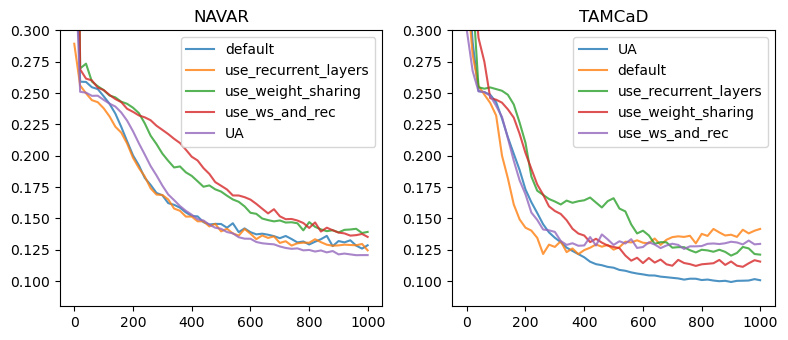

In [14]:
def plot_regression_noise_loss():

    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    
    # Iterate through each model
    for i, (model_name, result) in enumerate(all_results_list):
        n_ax = 0 if 'NAVAR' in model_name else 1
        tag = 'NAVAR' if 'NAVAR' in model_name else 'TAMCaD'
        result = result[0]
        axes[n_ax].plot(*result['test_metrics']['noise_adjusted_regression_loss'], label=model_name.replace(f'{tag}_', ''), alpha=0.8)
        axes[n_ax].set_title(tag)
        #axes[n_ax].set_xlim(100, 1000)
        axes[n_ax].set_ylim(0.08, 0.3)
        axes[n_ax].legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.savefig('noise_regression_losses.png', dpi=200)
    plt.show()
plot_regression_noise_loss()

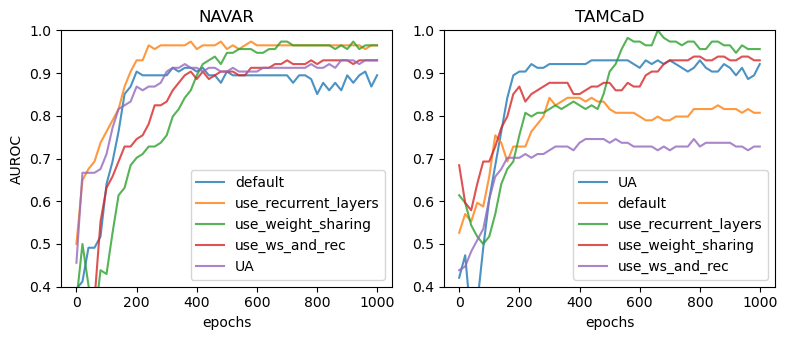

In [10]:
def plot_auroc():

    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))


    # Iterate through each model
    for i, (model_name, result) in enumerate(all_results_list):
        n_ax = 0 if 'NAVAR' in model_name else 1
        tag = 'NAVAR' if 'NAVAR' in model_name else 'TAMCaD'
        result = result[0]
        axes[n_ax].plot(*result['test_metrics']['AUROC'], label=model_name.replace(f'{tag}_', '') , alpha=0.8)
        axes[n_ax].set_title(tag)
        #axes[n_ax].set_xlim(40, 1200)
        axes[n_ax].set_ylim(0.4, 1.0)
        axes[n_ax].set_xlabel('epochs')
        axes[n_ax].legend()
    
    axes[0].set_ylabel('AUROC')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Display the plot
    plt.savefig('plot_auroc.png', dpi=200)
    plt.show()
plot_auroc()